In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

## Utils

In [2]:
def preprocess_pr_for_plot(pr: np.ndarray) -> np.ndarray:
    """Preprocesses a precision-recall (PR) array for plotting by sorting the rows by
    ascending recall values and inserting endpoints at recall=0 and recall=1.

    This function is designed to prepare precision-recall data for smooth plotting and
    interpolation by ensuring that the recall values are sorted in ascending order and
    that the precision-recall curve includes endpoints at recall values of 0 and 1.

    Parameters
    ----------
    pr : np.ndarray
        A 2D numpy array with shape (n_pr, 2) where the first column contains precision
        values and the second column contains recall values.

    Returns
    -------
    np.ndarray
        A 2D numpy array with shape (n_pr + 2, 2) where the rows are sorted by ascending
        recall values, and additional rows are inserted at the beginning and end to
        include the endpoints at recall=0 and recall=1.

    Example
    -------
    >>> pr = np.array([[0.8, 0.1], [0.6, 0.4], [0.9, 0.3]])
    >>> preprocess_pr_for_plot(pr)
    array([[0.8, 0. ],
       [0.8, 0.1],
       [0.9, 0.3],
       [0.6, 0.4],
       [0.6, 1. ]])
    """
    prec, rec = pr.T

    # sort by ascending recall values
    sort_by_rec = np.argsort(rec)
    pr_sorted = pr[sort_by_rec]

    # insert point at recall=0
    first_prec, first_rec = pr_sorted[0, 0], 0
    pr_sorted = np.insert(
        arr=pr_sorted, obj=0, values=np.array([first_prec, first_rec]), axis=0
    )

    # insert point at recall=1
    last_prec, last_rec = pr_sorted[-1, 0], 1
    pr_sorted = np.insert(
        arr=pr_sorted,
        obj=pr_sorted.shape[0],
        values=np.array([last_prec, last_rec]),
        axis=0,
    )

    return pr_sorted

In [3]:
def plot_pr_curve(pr: np.ndarray, ax=None, **plot_kwargs):
    """
    Plots a precision-recall curve using the same conventions as scikit-learn.

    This function takes a precision-recall array and plots the corresponding precision-recall
    curve. The precision-recall data is first preprocessed to ensure that recall values
    are sorted and endpoints are added for smooth plotting.

    Parameters
    ----------
    pr : np.ndarray
        A 2D numpy array with shape (n_pr, 2) where the first column contains precision
        values and the second column contains recall values.
    ax : matplotlib.axes.Axes, optional
        The axes object to draw the plot onto, or None to create a new figure and axes.
    **plot_kwargs
        Additional keyword arguments to pass to the `ax.plot` function.

    Returns
    -------
    matplotlib.axes.Axes
        The axes object with the precision-recall curve plotted.

    Example
    -------
    >>> import numpy as np
    >>> import matplotlib.pyplot as plt
    >>> pr = np.array([[0.8, 0.1], [0.6, 0.4], [0.9, 0.3]])
    >>> ax = plot_pr_curve(pr)
    >>> plt.show()
    """
    if ax is None:
        fig, ax = plt.subplots()

    pr = preprocess_pr_for_plot(pr)
    prec, rec = pr.T
    ax.plot(rec, prec, ls="--", drawstyle="steps-post", **plot_kwargs)
    ax.set(
        xlabel="Recall",
        xlim=(-0.01, 1.01),
        ylabel="Precision",
        ylim=(-0.01, 1.01),
        aspect="equal",
    )
    return ax

In [4]:
def compute_mean_pr_curve(all_pr, n_samples):
    """
    Computes the mean Precision-Recall (PR) curve along with the curves
    representing one standard deviation above and below the mean.

    Parameters:
    -----------
    all_pr : list of numpy.ndarray
        A list where each element is a numpy array of shape (n_pr, 2)
        representing precision and recall values.
    n_samples : int
        The desired number of samples for the approximation.

    Returns:
    --------
    pr_mean : numpy.ndarray
        A 2D array where the first column contains the mean precision values
        and the second column contains the corresponding recall values.
    pr_mean_plus_std : numpy.ndarray
        A 2D array where the first column contains the mean precision values
        plus one standard deviation and the second column contains the
        corresponding recall values.
    pr_mean_minus_std : numpy.ndarray
        A 2D array where the first column contains the mean precision values
        minus one standard deviation and the second column contains the
        corresponding recall values.

    Notes:
    ------
    This function interpolates the precision values for a common recall axis
    ranging from 0 to 1, then computes the mean and standard deviation of
    these interpolated precision values across all provided PR curves.
    """
    n_pr = len(all_pr)
    recall_axis = np.linspace(0, 1, n_samples, endpoint=True)

    all_approx = np.empty((n_pr, n_samples))

    for k_pr in range(n_pr):
        pr = all_pr[k_pr]
        p, r = preprocess_pr_for_plot(pr).T
        approx_fun = interp1d(r, p, kind="previous")
        approx = approx_fun(recall_axis)
        all_approx[k_pr] = approx
        plot_pr_curve(pr, ax=ax, color="b", alpha=0.2)

    prec_mean = all_approx.mean(0)
    prec_std = all_approx.std(0)
    prec_mean_plus_std = prec_mean + prec_std
    prec_mean_minus_std = prec_mean - prec_std

    pr_mean = np.c_[prec_mean, recall_axis]
    pr_mean_plus_std = np.c_[prec_mean_plus_std, recall_axis]
    pr_mean_minus_std = np.c_[prec_mean_minus_std, recall_axis]

    return pr_mean, pr_mean_plus_std, pr_mean_minus_std

In [5]:
def compute_pr_score(pr):
    """Computes the Average Precision (AP) score from a given Precision-Recall (PR) curve.

    Average Precision summarizes a precision-recall curve as the weighted mean
    of precisions achieved at each threshold, with the increase in recall from
    the previous threshold used as the weight.

    Parameters:
    -----------
    pr : numpy.ndarray
        A 2D array of shape (n, 2) where the first column represents precision
        values and the second column represents recall values.

    Returns:
    --------
    float
        The computed Average Precision (AP) score.

    Notes:
    ------
    This function uses a non-interpolated method for computing Average Precision,
    which sums the product of precision and recall differences at each threshold.

    For more details, see `sklearn.metrics.average_precision_score`.
    """
    prec, rec = pr.T
    sort_by_rec = np.argsort(rec)
    pr_sorted = pr[sort_by_rec]
    return -np.sum(np.diff(rec) * np.array(prec)[:-1])

## Test on dummy data

`all_pr`: A list where each element is a numpy array of shape (n_pr, 2) representing precision and recall values.

`all_pr[i]`: A 2D numpy array with shape (n_pr, 2) where the first column contains precision values and the second column contains recall values.

In [6]:
# fmt: off
all_pr = [np.array([[0.495, 1.0], [0.49748743718592964, 1.0], [0.5, 1.0], [0.5025380710659898, 1.0], [0.5051020408163265, 1.0], [0.5076923076923077, 1.0], [0.5103092783505154, 1.0], [0.5129533678756477, 1.0], [0.515625, 1.0], [0.518324607329843, 1.0], [0.5210526315789473, 1.0], [0.5238095238095238, 1.0], [0.526595744680851, 1.0], [0.5294117647058824, 1.0], [0.532258064516129, 1.0], [0.5351351351351351, 1.0], [0.5380434782608695, 1.0], [0.5409836065573771, 1.0], [0.5439560439560439, 1.0], [0.5469613259668509, 1.0], [0.55, 1.0], [0.553072625698324, 1.0], [0.5561797752808989, 1.0], [0.559322033898305, 1.0], [0.5625, 1.0], [0.5657142857142857, 1.0], [0.5689655172413793, 1.0], [0.5722543352601156, 1.0], [0.5755813953488372, 1.0], [0.5789473684210527, 1.0], [0.5764705882352941, 0.98989898989899], [0.5798816568047337, 0.98989898989899], [0.5833333333333334, 0.98989898989899], [0.5868263473053892, 0.98989898989899], [0.5903614457831325, 0.98989898989899], [0.593939393939394, 0.98989898989899], [0.5975609756097561, 0.98989898989899], [0.6012269938650306, 0.98989898989899], [0.6049382716049383, 0.98989898989899], [0.6086956521739131, 0.98989898989899], [0.6125, 0.98989898989899], [0.6163522012578616, 0.98989898989899], [0.620253164556962, 0.98989898989899], [0.6242038216560509, 0.98989898989899], [0.6282051282051282, 0.98989898989899], [0.632258064516129, 0.98989898989899], [0.6363636363636364, 0.98989898989899], [0.6339869281045751, 0.9797979797979798], [0.6381578947368421, 0.9797979797979798], [0.6423841059602649, 0.9797979797979798], [0.6466666666666666, 0.9797979797979798], [0.6510067114093959, 0.9797979797979798], [0.6554054054054054, 0.9797979797979798], [0.6530612244897959, 0.9696969696969697], [0.6575342465753424, 0.9696969696969697], [0.6620689655172414, 0.9696969696969697], [0.6666666666666666, 0.9696969696969697], [0.6643356643356644, 0.9595959595959596], [0.6690140845070423, 0.9595959595959596], [0.6737588652482269, 0.9595959595959596], [0.6785714285714286, 0.9595959595959596], [0.6762589928057554, 0.9494949494949495], [0.6739130434782609, 0.9393939393939394], [0.6788321167883211, 0.9393939393939394], [0.6764705882352942, 0.9292929292929293], [0.674074074074074, 0.9191919191919192], [0.6716417910447762, 0.9090909090909091], [0.6766917293233082, 0.9090909090909091], [0.6742424242424242, 0.898989898989899], [0.6793893129770993, 0.898989898989899], [0.6846153846153846, 0.898989898989899], [0.689922480620155, 0.898989898989899], [0.6875, 0.8888888888888888], [0.6929133858267716, 0.8888888888888888], [0.6904761904761905, 0.8787878787878788], [0.688, 0.8686868686868687], [0.6854838709677419, 0.8585858585858586], [0.6829268292682927, 0.8484848484848485], [0.6885245901639344, 0.8484848484848485], [0.6859504132231405, 0.8383838383838383], [0.6916666666666667, 0.8383838383838383], [0.6974789915966386, 0.8383838383838383], [0.7033898305084746, 0.8383838383838383], [0.7094017094017094, 0.8383838383838383], [0.7155172413793104, 0.8383838383838383], [0.7217391304347827, 0.8383838383838383], [0.7280701754385965, 0.8383838383838383], [0.7345132743362832, 0.8383838383838383], [0.7321428571428571, 0.8282828282828283], [0.7387387387387387, 0.8282828282828283], [0.7454545454545455, 0.8282828282828283], [0.7522935779816514, 0.8282828282828283], [0.7592592592592593, 0.8282828282828283], [0.7663551401869159, 0.8282828282828283], [0.7641509433962265, 0.8181818181818182], [0.7714285714285715, 0.8181818181818182], [0.7788461538461539, 0.8181818181818182], [0.7766990291262136, 0.8080808080808081], [0.7843137254901961, 0.8080808080808081], [0.7821782178217822, 0.797979797979798], [0.78, 0.7878787878787878], [0.7878787878787878, 0.7878787878787878], [0.7857142857142857, 0.7777777777777778], [0.8105263157894737, 0.7777777777777778], [0.8085106382978723, 0.7676767676767676], [0.8172043010752689, 0.7676767676767676], [0.8152173913043478, 0.7575757575757576], [0.8131868131868132, 0.7474747474747475], [0.8222222222222222, 0.7474747474747475], [0.8314606741573034, 0.7474747474747475], [0.8295454545454546, 0.7373737373737373], [0.8390804597701149, 0.7373737373737373], [0.8488372093023255, 0.7373737373737373], [0.8470588235294118, 0.7272727272727273], [0.8452380952380952, 0.7171717171717171], [0.8554216867469879, 0.7171717171717171], [0.8658536585365854, 0.7171717171717171], [0.8641975308641975, 0.7070707070707071], [0.8625, 0.696969696969697], [0.8734177215189873, 0.696969696969697], [0.8717948717948718, 0.6868686868686869], [0.8701298701298701, 0.6767676767676768], [0.868421052631579, 0.6666666666666666], [0.8666666666666667, 0.6565656565656566], [0.8648648648648649, 0.6464646464646465], [0.8767123287671232, 0.6464646464646465], [0.8888888888888888, 0.6464646464646465], [0.9014084507042254, 0.6464646464646465], [0.9, 0.6363636363636364], [0.8985507246376812, 0.6262626262626263], [0.8970588235294118, 0.6161616161616161], [0.8955223880597015, 0.6060606060606061], [0.8939393939393939, 0.5959595959595959], [0.8923076923076924, 0.5858585858585859], [0.90625, 0.5858585858585859], [0.9047619047619048, 0.5757575757575758], [0.9032258064516129, 0.5656565656565656], [0.9016393442622951, 0.5555555555555556], [0.9166666666666666, 0.5555555555555556], [0.9152542372881356, 0.5454545454545454], [0.9137931034482759, 0.5353535353535354], [0.9122807017543859, 0.5252525252525253], [0.9107142857142857, 0.5151515151515151], [0.9272727272727272, 0.5151515151515151], [0.9259259259259259, 0.5050505050505051], [0.9245283018867925, 0.494949494949495], [0.9423076923076923, 0.494949494949495], [0.9411764705882353, 0.48484848484848486], [0.94, 0.47474747474747475], [0.9387755102040817, 0.46464646464646464], [0.9375, 0.45454545454545453], [0.9574468085106383, 0.45454545454545453], [0.9565217391304348, 0.4444444444444444], [0.9555555555555556, 0.43434343434343436], [0.9545454545454546, 0.42424242424242425], [0.9534883720930233, 0.41414141414141414], [0.9523809523809523, 0.40404040404040403], [0.9512195121951219, 0.3939393939393939], [0.95, 0.3838383838383838], [0.9743589743589743, 0.3838383838383838], [0.9736842105263158, 0.37373737373737376], [0.972972972972973, 0.36363636363636365], [0.9722222222222222, 0.35353535353535354], [0.9714285714285714, 0.3434343434343434], [0.9705882352941176, 0.3333333333333333], [0.9696969696969697, 0.32323232323232326], [0.96875, 0.31313131313131315], [0.967741935483871, 0.30303030303030304], [0.9666666666666667, 0.29292929292929293], [0.9655172413793104, 0.2828282828282828], [0.9642857142857143, 0.2727272727272727], [0.9629629629629629, 0.26262626262626265], [0.9615384615384616, 0.25252525252525254], [0.96, 0.24242424242424243], [0.9583333333333334, 0.23232323232323232], [0.9565217391304348, 0.2222222222222222], [0.9545454545454546, 0.21212121212121213], [0.9523809523809523, 0.20202020202020202], [1.0, 0.20202020202020202], [1.0, 0.1919191919191919], [1.0, 0.18181818181818182], [1.0, 0.1717171717171717], [1.0, 0.16161616161616163], [1.0, 0.15151515151515152], [1.0, 0.1414141414141414], [1.0, 0.13131313131313133], [1.0, 0.12121212121212122], [1.0, 0.1111111111111111], [1.0, 0.10101010101010101], [1.0, 0.09090909090909091], [1.0, 0.08080808080808081], [1.0, 0.0707070707070707], [1.0, 0.06060606060606061], [1.0, 0.050505050505050504], [1.0, 0.04040404040404041], [1.0, 0.030303030303030304], [1.0, 0.020202020202020204], [1.0, 0.010101010101010102], [1.0, 0.0]]
), np.array([[0.485, 1.0], [0.48743718592964824, 1.0], [0.4898989898989899, 1.0], [0.49238578680203043, 1.0], [0.49489795918367346, 1.0], [0.49743589743589745, 1.0], [0.5, 1.0], [0.5025906735751295, 1.0], [0.5052083333333334, 1.0], [0.5078534031413613, 1.0], [0.5105263157894737, 1.0], [0.5132275132275133, 1.0], [0.5159574468085106, 1.0], [0.5133689839572193, 0.9896907216494846], [0.5161290322580645, 0.9896907216494846], [0.5135135135135135, 0.979381443298969], [0.5163043478260869, 0.979381443298969], [0.5191256830601093, 0.979381443298969], [0.521978021978022, 0.979381443298969], [0.5248618784530387, 0.979381443298969], [0.5277777777777778, 0.979381443298969], [0.5307262569832403, 0.979381443298969], [0.5337078651685393, 0.979381443298969], [0.536723163841808, 0.979381443298969], [0.5340909090909091, 0.9690721649484536], [0.5314285714285715, 0.9587628865979382], [0.5344827586206896, 0.9587628865979382], [0.5375722543352601, 0.9587628865979382], [0.5406976744186046, 0.9587628865979382], [0.5380116959064327, 0.9484536082474226], [0.5411764705882353, 0.9484536082474226], [0.5443786982248521, 0.9484536082474226], [0.5476190476190477, 0.9484536082474226], [0.5508982035928144, 0.9484536082474226], [0.5542168674698795, 0.9484536082474226], [0.5575757575757576, 0.9484536082474226], [0.5609756097560976, 0.9484536082474226], [0.558282208588957, 0.9381443298969072], [0.5617283950617284, 0.9381443298969072], [0.5652173913043478, 0.9381443298969072], [0.56875, 0.9381443298969072], [0.5723270440251572, 0.9381443298969072], [0.5759493670886076, 0.9381443298969072], [0.5732484076433121, 0.9278350515463918], [0.5769230769230769, 0.9278350515463918], [0.5806451612903226, 0.9278350515463918], [0.5844155844155844, 0.9278350515463918], [0.5882352941176471, 0.9278350515463918], [0.5921052631578947, 0.9278350515463918], [0.5894039735099338, 0.9175257731958762], [0.5933333333333334, 0.9175257731958762], [0.5973154362416108, 0.9175257731958762], [0.5945945945945946, 0.9072164948453608], [0.5918367346938775, 0.8969072164948454], [0.5958904109589042, 0.8969072164948454], [0.6, 0.8969072164948454], [0.6041666666666666, 0.8969072164948454], [0.6083916083916084, 0.8969072164948454], [0.6126760563380281, 0.8969072164948454], [0.6170212765957447, 0.8969072164948454], [0.6214285714285714, 0.8969072164948454], [0.6258992805755396, 0.8969072164948454], [0.6304347826086957, 0.8969072164948454], [0.6277372262773723, 0.8865979381443299], [0.6323529411764706, 0.8865979381443299], [0.6370370370370371, 0.8865979381443299], [0.6417910447761194, 0.8865979381443299], [0.6390977443609023, 0.8762886597938144], [0.6363636363636364, 0.865979381443299], [0.6412213740458015, 0.865979381443299], [0.6384615384615384, 0.8556701030927835], [0.6356589147286822, 0.845360824742268], [0.640625, 0.845360824742268], [0.6456692913385826, 0.845360824742268], [0.6507936507936508, 0.845360824742268], [0.656, 0.845360824742268], [0.6532258064516129, 0.8350515463917526], [0.6585365853658537, 0.8350515463917526], [0.6639344262295082, 0.8350515463917526], [0.6611570247933884, 0.8247422680412371], [0.6666666666666666, 0.8247422680412371], [0.6722689075630253, 0.8247422680412371], [0.6779661016949152, 0.8247422680412371], [0.6837606837606838, 0.8247422680412371], [0.6896551724137931, 0.8247422680412371], [0.6956521739130435, 0.8247422680412371], [0.6929824561403509, 0.8144329896907216], [0.6991150442477876, 0.8144329896907216], [0.7053571428571429, 0.8144329896907216], [0.7117117117117117, 0.8144329896907216], [0.7181818181818181, 0.8144329896907216], [0.7155963302752294, 0.8041237113402062], [0.7222222222222222, 0.8041237113402062], [0.7289719626168224, 0.8041237113402062], [0.7264150943396226, 0.7938144329896907], [0.7378640776699029, 0.7835051546391752], [0.7450980392156863, 0.7835051546391752], [0.7524752475247525, 0.7835051546391752], [0.76, 0.7835051546391752], [0.7676767676767676, 0.7835051546391752], [0.7653061224489796, 0.7731958762886598], [0.7628865979381443, 0.7628865979381443], [0.7604166666666666, 0.7525773195876289], [0.7684210526315789, 0.7525773195876289], [0.7659574468085106, 0.7422680412371134], [0.7634408602150538, 0.7319587628865979], [0.7608695652173914, 0.7216494845360825], [0.7692307692307693, 0.7216494845360825], [0.7777777777777778, 0.7216494845360825], [0.7752808988764045, 0.711340206185567], [0.7727272727272727, 0.7010309278350515], [0.7816091954022989, 0.7010309278350515], [0.7906976744186046, 0.7010309278350515], [0.788235294117647, 0.6907216494845361], [0.7976190476190477, 0.6907216494845361], [0.7951807228915663, 0.6804123711340206], [0.7926829268292683, 0.6701030927835051], [0.7901234567901234, 0.6597938144329897], [0.7875, 0.6494845360824743], [0.7848101265822784, 0.6391752577319587], [0.7948717948717948, 0.6391752577319587], [0.7922077922077922, 0.6288659793814433], [0.8026315789473685, 0.6288659793814433], [0.8, 0.6185567010309279], [0.8108108108108109, 0.6185567010309279], [0.8082191780821918, 0.6082474226804123], [0.8055555555555556, 0.5979381443298969], [0.8169014084507042, 0.5979381443298969], [0.8285714285714286, 0.5979381443298969], [0.8405797101449275, 0.5979381443298969], [0.8382352941176471, 0.5876288659793815], [0.835820895522388, 0.5773195876288659], [0.8484848484848485, 0.5773195876288659], [0.8461538461538461, 0.5670103092783505], [0.859375, 0.5670103092783505], [0.873015873015873, 0.5670103092783505], [0.8709677419354839, 0.5567010309278351], [0.8688524590163934, 0.5463917525773195], [0.8833333333333333, 0.5463917525773195], [0.8813559322033898, 0.5360824742268041], [0.8793103448275862, 0.5257731958762887], [0.8947368421052632, 0.5257731958762887], [0.8928571428571429, 0.5154639175257731], [0.8909090909090909, 0.5051546391752577], [0.8888888888888888, 0.4948453608247423], [0.8867924528301887, 0.4845360824742268], [0.8846153846153846, 0.4742268041237113], [0.8823529411764706, 0.4639175257731959], [0.88, 0.4536082474226804], [0.8775510204081632, 0.44329896907216493], [0.875, 0.4329896907216495], [0.8723404255319149, 0.422680412371134], [0.8913043478260869, 0.422680412371134], [0.8888888888888888, 0.41237113402061853], [0.9090909090909091, 0.41237113402061853], [0.9302325581395349, 0.41237113402061853], [0.9285714285714286, 0.4020618556701031], [0.926829268292683, 0.3917525773195876], [0.925, 0.38144329896907214], [0.9230769230769231, 0.3711340206185567], [0.9210526315789473, 0.36082474226804123], [0.918918918918919, 0.35051546391752575], [0.9166666666666666, 0.3402061855670103], [0.9142857142857143, 0.32989690721649484], [0.9117647058823529, 0.31958762886597936], [0.9090909090909091, 0.30927835051546393], [0.9375, 0.30927835051546393], [0.9354838709677419, 0.29896907216494845], [0.9333333333333333, 0.28865979381443296], [0.9310344827586207, 0.27835051546391754], [0.9285714285714286, 0.26804123711340205], [0.9259259259259259, 0.25773195876288657], [0.9230769230769231, 0.24742268041237114], [0.92, 0.23711340206185566], [0.9166666666666666, 0.2268041237113402], [0.9130434782608695, 0.21649484536082475], [0.9090909090909091, 0.20618556701030927], [0.9047619047619048, 0.1958762886597938], [0.9, 0.18556701030927836], [0.9473684210526315, 0.18556701030927836], [0.9444444444444444, 0.17525773195876287], [0.9411764705882353, 0.16494845360824742], [0.9375, 0.15463917525773196], [0.9333333333333333, 0.14432989690721648], [0.9285714285714286, 0.13402061855670103], [1.0, 0.13402061855670103], [1.0, 0.12371134020618557], [1.0, 0.1134020618556701], [1.0, 0.10309278350515463], [1.0, 0.09278350515463918], [1.0, 0.08247422680412371], [1.0, 0.07216494845360824], [1.0, 0.061855670103092786], [1.0, 0.05154639175257732], [1.0, 0.041237113402061855], [1.0, 0.030927835051546393], [1.0, 0.020618556701030927], [1.0, 0.010309278350515464], [1.0, 0.0]]
), np.array([[0.535, 1.0], [0.5376884422110553, 1.0], [0.5404040404040404, 1.0], [0.5431472081218274, 1.0], [0.5459183673469388, 1.0], [0.5487179487179488, 1.0], [0.5515463917525774, 1.0], [0.5544041450777202, 1.0], [0.5572916666666666, 1.0], [0.5602094240837696, 1.0], [0.5631578947368421, 1.0], [0.5661375661375662, 1.0], [0.5691489361702128, 1.0], [0.5668449197860963, 0.9906542056074766], [0.5698924731182796, 0.9906542056074766], [0.572972972972973, 0.9906542056074766], [0.5760869565217391, 0.9906542056074766], [0.5792349726775956, 0.9906542056074766], [0.5824175824175825, 0.9906542056074766], [0.585635359116022, 0.9906542056074766], [0.5888888888888889, 0.9906542056074766], [0.5921787709497207, 0.9906542056074766], [0.5955056179775281, 0.9906542056074766], [0.5988700564971752, 0.9906542056074766], [0.6022727272727273, 0.9906542056074766], [0.6057142857142858, 0.9906542056074766], [0.6091954022988506, 0.9906542056074766], [0.6069364161849711, 0.9813084112149533], [0.6104651162790697, 0.9813084112149533], [0.6140350877192983, 0.9813084112149533], [0.6176470588235294, 0.9813084112149533], [0.6153846153846154, 0.9719626168224299], [0.6190476190476191, 0.9719626168224299], [0.6227544910179641, 0.9719626168224299], [0.6265060240963856, 0.9719626168224299], [0.6303030303030303, 0.9719626168224299], [0.6341463414634146, 0.9719626168224299], [0.6380368098159509, 0.9719626168224299], [0.6358024691358025, 0.9626168224299065], [0.639751552795031, 0.9626168224299065], [0.64375, 0.9626168224299065], [0.6477987421383647, 0.9626168224299065], [0.6455696202531646, 0.9532710280373832], [0.643312101910828, 0.9439252336448598], [0.6474358974358975, 0.9439252336448598], [0.6451612903225806, 0.9345794392523364], [0.6493506493506493, 0.9345794392523364], [0.6470588235294118, 0.9252336448598131], [0.6513157894736842, 0.9252336448598131], [0.6556291390728477, 0.9252336448598131], [0.66, 0.9252336448598131], [0.6577181208053692, 0.9158878504672897], [0.6621621621621622, 0.9158878504672897], [0.6666666666666666, 0.9158878504672897], [0.6712328767123288, 0.9158878504672897], [0.6758620689655173, 0.9158878504672897], [0.6736111111111112, 0.9065420560747663], [0.6783216783216783, 0.9065420560747663], [0.6830985915492958, 0.9065420560747663], [0.6879432624113475, 0.9065420560747663], [0.6857142857142857, 0.897196261682243], [0.6906474820143885, 0.897196261682243], [0.6884057971014492, 0.8878504672897196], [0.6861313868613139, 0.8785046728971962], [0.6911764705882353, 0.8785046728971962], [0.6962962962962963, 0.8785046728971962], [0.6940298507462687, 0.8691588785046729], [0.6992481203007519, 0.8691588785046729], [0.7045454545454546, 0.8691588785046729], [0.7099236641221374, 0.8691588785046729], [0.7153846153846154, 0.8691588785046729], [0.7209302325581395, 0.8691588785046729], [0.7265625, 0.8691588785046729], [0.7322834645669292, 0.8691588785046729], [0.7380952380952381, 0.8691588785046729], [0.744, 0.8691588785046729], [0.75, 0.8691588785046729], [0.7560975609756098, 0.8691588785046729], [0.7622950819672131, 0.8691588785046729], [0.768595041322314, 0.8691588785046729], [0.7666666666666667, 0.8598130841121495], [0.773109243697479, 0.8598130841121495], [0.7711864406779662, 0.8504672897196262], [0.7692307692307693, 0.8411214953271028], [0.7672413793103449, 0.8317757009345794], [0.7739130434782608, 0.8317757009345794], [0.7807017543859649, 0.8317757009345794], [0.7787610619469026, 0.822429906542056], [0.7767857142857143, 0.8130841121495327], [0.7747747747747747, 0.8037383177570093], [0.7818181818181819, 0.8037383177570093], [0.7798165137614679, 0.794392523364486], [0.7777777777777778, 0.7850467289719626], [0.7757009345794392, 0.7757009345794392], [0.7735849056603774, 0.7663551401869159], [0.7714285714285715, 0.7570093457943925], [0.7788461538461539, 0.7570093457943925], [0.7766990291262136, 0.7476635514018691], [0.7745098039215687, 0.7383177570093458], [0.7821782178217822, 0.7383177570093458], [0.78, 0.7289719626168224], [0.7878787878787878, 0.7289719626168224], [0.7959183673469388, 0.7289719626168224], [0.7938144329896907, 0.719626168224299], [0.7916666666666666, 0.7102803738317757], [0.7894736842105263, 0.7009345794392523], [0.7872340425531915, 0.6915887850467289], [0.7849462365591398, 0.6822429906542056], [0.7934782608695652, 0.6822429906542056], [0.8021978021978022, 0.6822429906542056], [0.8, 0.6728971962616822], [0.8089887640449438, 0.6728971962616822], [0.8181818181818182, 0.6728971962616822], [0.8160919540229885, 0.6635514018691588], [0.8255813953488372, 0.6635514018691588], [0.8235294117647058, 0.6542056074766355], [0.8214285714285714, 0.6448598130841121], [0.8192771084337349, 0.6355140186915887], [0.8292682926829268, 0.6355140186915887], [0.8271604938271605, 0.6261682242990654], [0.825, 0.616822429906542], [0.8227848101265823, 0.6074766355140186], [0.8333333333333334, 0.6074766355140186], [0.8441558441558441, 0.6074766355140186], [0.8421052631578947, 0.5981308411214953], [0.84, 0.5887850467289719], [0.8378378378378378, 0.5794392523364486], [0.8356164383561644, 0.5700934579439252], [0.8333333333333334, 0.5607476635514018], [0.8309859154929577, 0.5514018691588785], [0.8285714285714286, 0.5420560747663551], [0.8260869565217391, 0.5327102803738317], [0.8382352941176471, 0.5327102803738317], [0.8507462686567164, 0.5327102803738317], [0.8484848484848485, 0.5233644859813084], [0.8461538461538461, 0.514018691588785], [0.84375, 0.5046728971962616], [0.8412698412698413, 0.4953271028037383], [0.8387096774193549, 0.48598130841121495], [0.8524590163934426, 0.48598130841121495], [0.8666666666666667, 0.48598130841121495], [0.864406779661017, 0.4766355140186916], [0.8620689655172413, 0.4672897196261682], [0.8596491228070176, 0.45794392523364486], [0.875, 0.45794392523364486], [0.8727272727272727, 0.4485981308411215], [0.8888888888888888, 0.4485981308411215], [0.8867924528301887, 0.4392523364485981], [0.8846153846153846, 0.42990654205607476], [0.8823529411764706, 0.4205607476635514], [0.88, 0.411214953271028], [0.8775510204081632, 0.40186915887850466], [0.875, 0.3925233644859813], [0.8936170212765957, 0.3925233644859813], [0.9130434782608695, 0.3925233644859813], [0.9111111111111111, 0.38317757009345793], [0.9090909090909091, 0.37383177570093457], [0.9069767441860465, 0.3644859813084112], [0.9047619047619048, 0.35514018691588783], [0.9024390243902439, 0.34579439252336447], [0.9, 0.3364485981308411], [0.9230769230769231, 0.3364485981308411], [0.9210526315789473, 0.32710280373831774], [0.918918918918919, 0.3177570093457944], [0.9166666666666666, 0.308411214953271], [0.9142857142857143, 0.29906542056074764], [0.9117647058823529, 0.2897196261682243], [0.9090909090909091, 0.2803738317757009], [0.90625, 0.27102803738317754], [0.9032258064516129, 0.2616822429906542], [0.9, 0.2523364485981308], [0.896551724137931, 0.24299065420560748], [0.8928571428571429, 0.2336448598130841], [0.8888888888888888, 0.22429906542056074], [0.8846153846153846, 0.21495327102803738], [0.88, 0.205607476635514], [0.875, 0.19626168224299065], [0.8695652173913043, 0.18691588785046728], [0.8636363636363636, 0.17757009345794392], [0.8571428571428571, 0.16822429906542055], [0.9, 0.16822429906542055], [0.8947368421052632, 0.1588785046728972], [0.8888888888888888, 0.14953271028037382], [0.8823529411764706, 0.14018691588785046], [0.875, 0.1308411214953271], [0.8666666666666667, 0.12149532710280374], [0.8571428571428571, 0.11214953271028037], [0.8461538461538461, 0.102803738317757], [0.8333333333333334, 0.09345794392523364], [0.9090909090909091, 0.09345794392523364], [0.9, 0.08411214953271028], [0.8888888888888888, 0.07476635514018691], [0.875, 0.06542056074766354], [0.8571428571428571, 0.056074766355140186], [1.0, 0.056074766355140186], [1.0, 0.04672897196261682], [1.0, 0.037383177570093455], [1.0, 0.028037383177570093], [1.0, 0.018691588785046728], [1.0, 0.009345794392523364], [1.0, 0.0]]
), np.array([[0.48, 1.0], [0.4824120603015075, 1.0], [0.48484848484848486, 1.0], [0.4873096446700508, 1.0], [0.4897959183673469, 1.0], [0.49230769230769234, 1.0], [0.4948453608247423, 1.0], [0.49740932642487046, 1.0], [0.4947916666666667, 0.9895833333333334], [0.4973821989528796, 0.9895833333333334], [0.5, 0.9895833333333334], [0.5026455026455027, 0.9895833333333334], [0.5053191489361702, 0.9895833333333334], [0.5080213903743316, 0.9895833333333334], [0.510752688172043, 0.9895833333333334], [0.5135135135135135, 0.9895833333333334], [0.5163043478260869, 0.9895833333333334], [0.5191256830601093, 0.9895833333333334], [0.521978021978022, 0.9895833333333334], [0.5248618784530387, 0.9895833333333334], [0.5277777777777778, 0.9895833333333334], [0.5307262569832403, 0.9895833333333334], [0.5337078651685393, 0.9895833333333334], [0.536723163841808, 0.9895833333333334], [0.5397727272727273, 0.9895833333333334], [0.5428571428571428, 0.9895833333333334], [0.5459770114942529, 0.9895833333333334], [0.5491329479768786, 0.9895833333333334], [0.5523255813953488, 0.9895833333333334], [0.5497076023391813, 0.9791666666666666], [0.5529411764705883, 0.9791666666666666], [0.5562130177514792, 0.9791666666666666], [0.5595238095238095, 0.9791666666666666], [0.562874251497006, 0.9791666666666666], [0.5662650602409639, 0.9791666666666666], [0.5696969696969697, 0.9791666666666666], [0.5670731707317073, 0.96875], [0.5705521472392638, 0.96875], [0.5740740740740741, 0.96875], [0.577639751552795, 0.96875], [0.575, 0.9583333333333334], [0.5786163522012578, 0.9583333333333334], [0.5822784810126582, 0.9583333333333334], [0.5859872611464968, 0.9583333333333334], [0.5897435897435898, 0.9583333333333334], [0.5935483870967742, 0.9583333333333334], [0.5974025974025974, 0.9583333333333334], [0.6013071895424836, 0.9583333333333334], [0.6052631578947368, 0.9583333333333334], [0.609271523178808, 0.9583333333333334], [0.6133333333333333, 0.9583333333333334], [0.6174496644295302, 0.9583333333333334], [0.6216216216216216, 0.9583333333333334], [0.6258503401360545, 0.9583333333333334], [0.6301369863013698, 0.9583333333333334], [0.6344827586206897, 0.9583333333333334], [0.6388888888888888, 0.9583333333333334], [0.6363636363636364, 0.9479166666666666], [0.6408450704225352, 0.9479166666666666], [0.6453900709219859, 0.9479166666666666], [0.6428571428571429, 0.9375], [0.6402877697841727, 0.9270833333333334], [0.644927536231884, 0.9270833333333334], [0.6423357664233577, 0.9166666666666666], [0.6470588235294118, 0.9166666666666666], [0.6518518518518519, 0.9166666666666666], [0.6567164179104478, 0.9166666666666666], [0.6616541353383458, 0.9166666666666666], [0.6666666666666666, 0.9166666666666666], [0.6717557251908397, 0.9166666666666666], [0.6692307692307692, 0.90625], [0.6744186046511628, 0.90625], [0.6796875, 0.90625], [0.6850393700787402, 0.90625], [0.6904761904761905, 0.90625], [0.688, 0.8958333333333334], [0.6935483870967742, 0.8958333333333334], [0.6991869918699187, 0.8958333333333334], [0.7049180327868853, 0.8958333333333334], [0.7107438016528925, 0.8958333333333334], [0.7166666666666667, 0.8958333333333334], [0.7226890756302521, 0.8958333333333334], [0.7203389830508474, 0.8854166666666666], [0.7264957264957265, 0.8854166666666666], [0.7241379310344828, 0.875], [0.7304347826086957, 0.875], [0.7280701754385965, 0.8645833333333334], [0.7345132743362832, 0.8645833333333334], [0.7410714285714286, 0.8645833333333334], [0.7477477477477478, 0.8645833333333334], [0.7545454545454545, 0.8645833333333334], [0.7614678899082569, 0.8645833333333334], [0.7592592592592593, 0.8541666666666666], [0.7570093457943925, 0.84375], [0.7641509433962265, 0.84375], [0.7692307692307693, 0.8333333333333334], [0.7766990291262136, 0.8333333333333334], [0.7745098039215687, 0.8229166666666666], [0.7821782178217822, 0.8229166666666666], [0.79, 0.8229166666666666], [0.7878787878787878, 0.8125], [0.7857142857142857, 0.8020833333333334], [0.7938144329896907, 0.8020833333333334], [0.8020833333333334, 0.8020833333333334], [0.8, 0.7916666666666666], [0.8085106382978723, 0.7916666666666666], [0.8172043010752689, 0.7916666666666666], [0.8152173913043478, 0.78125], [0.8131868131868132, 0.7708333333333334], [0.8111111111111111, 0.7604166666666666], [0.8202247191011236, 0.7604166666666666], [0.8181818181818182, 0.75], [0.8160919540229885, 0.7395833333333334], [0.813953488372093, 0.7291666666666666], [0.8117647058823529, 0.71875], [0.8214285714285714, 0.71875], [0.8192771084337349, 0.7083333333333334], [0.8292682926829268, 0.7083333333333334], [0.8395061728395061, 0.7083333333333334], [0.8375, 0.6979166666666666], [0.8354430379746836, 0.6875], [0.8333333333333334, 0.6770833333333334], [0.8311688311688312, 0.6666666666666666], [0.8421052631578947, 0.6666666666666666], [0.84, 0.65625], [0.8513513513513513, 0.65625], [0.8493150684931506, 0.6458333333333334], [0.8472222222222222, 0.6354166666666666], [0.8591549295774648, 0.6354166666666666], [0.8571428571428571, 0.625], [0.855072463768116, 0.6145833333333334], [0.8676470588235294, 0.6145833333333334], [0.8656716417910447, 0.6041666666666666], [0.8636363636363636, 0.59375], [0.8615384615384616, 0.5833333333333334], [0.859375, 0.5729166666666666], [0.8571428571428571, 0.5625], [0.8548387096774194, 0.5520833333333334], [0.8524590163934426, 0.5416666666666666], [0.85, 0.53125], [0.864406779661017, 0.53125], [0.8620689655172413, 0.5208333333333334], [0.8596491228070176, 0.5104166666666666], [0.8571428571428571, 0.5], [0.8727272727272727, 0.5], [0.8703703703703703, 0.4895833333333333], [0.8679245283018868, 0.4791666666666667], [0.8653846153846154, 0.46875], [0.8627450980392157, 0.4583333333333333], [0.88, 0.4583333333333333], [0.8979591836734694, 0.4583333333333333], [0.8958333333333334, 0.4479166666666667], [0.9148936170212766, 0.4479166666666667], [0.9130434782608695, 0.4375], [0.9111111111111111, 0.4270833333333333], [0.9090909090909091, 0.4166666666666667], [0.9069767441860465, 0.40625], [0.9285714285714286, 0.40625], [0.926829268292683, 0.3958333333333333], [0.925, 0.3854166666666667], [0.9487179487179487, 0.3854166666666667], [0.9473684210526315, 0.375], [0.9459459459459459, 0.3645833333333333], [0.9444444444444444, 0.3541666666666667], [0.9428571428571428, 0.34375], [0.9411764705882353, 0.3333333333333333], [0.9393939393939394, 0.3229166666666667], [0.9375, 0.3125], [0.9354838709677419, 0.3020833333333333], [0.9333333333333333, 0.2916666666666667], [0.9310344827586207, 0.28125], [0.9642857142857143, 0.28125], [0.9629629629629629, 0.2708333333333333], [0.9615384615384616, 0.2604166666666667], [0.96, 0.25], [0.9583333333333334, 0.23958333333333334], [0.9565217391304348, 0.22916666666666666], [1.0, 0.22916666666666666], [1.0, 0.21875], [1.0, 0.20833333333333334], [1.0, 0.19791666666666666], [1.0, 0.1875], [1.0, 0.17708333333333334], [1.0, 0.16666666666666666], [1.0, 0.15625], [1.0, 0.14583333333333334], [1.0, 0.13541666666666666], [1.0, 0.125], [1.0, 0.11458333333333333], [1.0, 0.10416666666666667], [1.0, 0.09375], [1.0, 0.08333333333333333], [1.0, 0.07291666666666667], [1.0, 0.0625], [1.0, 0.052083333333333336], [1.0, 0.041666666666666664], [1.0, 0.03125], [1.0, 0.020833333333333332], [1.0, 0.010416666666666666], [1.0, 0.0]]
), np.array([[0.505, 1.0], [0.507537688442211, 1.0], [0.51010101010101, 1.0], [0.5126903553299492, 1.0], [0.5153061224489796, 1.0], [0.517948717948718, 1.0], [0.520618556701031, 1.0], [0.5233160621761658, 1.0], [0.5260416666666666, 1.0], [0.5287958115183246, 1.0], [0.531578947368421, 1.0], [0.5343915343915344, 1.0], [0.5372340425531915, 1.0], [0.5401069518716578, 1.0], [0.543010752688172, 1.0], [0.5459459459459459, 1.0], [0.5434782608695652, 0.9900990099009901], [0.5409836065573771, 0.9801980198019802], [0.5439560439560439, 0.9801980198019802], [0.5414364640883977, 0.9702970297029703], [0.5444444444444444, 0.9702970297029703], [0.547486033519553, 0.9702970297029703], [0.550561797752809, 0.9702970297029703], [0.5536723163841808, 0.9702970297029703], [0.5568181818181818, 0.9702970297029703], [0.56, 0.9702970297029703], [0.5632183908045977, 0.9702970297029703], [0.5664739884393064, 0.9702970297029703], [0.563953488372093, 0.9603960396039604], [0.5672514619883041, 0.9603960396039604], [0.5705882352941176, 0.9603960396039604], [0.5739644970414202, 0.9603960396039604], [0.5773809523809523, 0.9603960396039604], [0.5748502994011976, 0.9504950495049505], [0.572289156626506, 0.9405940594059405], [0.5757575757575758, 0.9405940594059405], [0.5792682926829268, 0.9405940594059405], [0.5828220858895705, 0.9405940594059405], [0.5864197530864198, 0.9405940594059405], [0.5838509316770186, 0.9306930693069307], [0.5875, 0.9306930693069307], [0.5911949685534591, 0.9306930693069307], [0.5886075949367089, 0.9207920792079208], [0.5923566878980892, 0.9207920792079208], [0.5961538461538461, 0.9207920792079208], [0.6, 0.9207920792079208], [0.6038961038961039, 0.9207920792079208], [0.6078431372549019, 0.9207920792079208], [0.6118421052631579, 0.9207920792079208], [0.609271523178808, 0.9108910891089109], [0.6133333333333333, 0.9108910891089109], [0.6174496644295302, 0.9108910891089109], [0.6148648648648649, 0.900990099009901], [0.6190476190476191, 0.900990099009901], [0.6232876712328768, 0.900990099009901], [0.6206896551724138, 0.8910891089108911], [0.625, 0.8910891089108911], [0.6293706293706294, 0.8910891089108911], [0.6267605633802817, 0.8811881188118812], [0.6312056737588653, 0.8811881188118812], [0.6357142857142857, 0.8811881188118812], [0.6402877697841727, 0.8811881188118812], [0.644927536231884, 0.8811881188118812], [0.6423357664233577, 0.8712871287128713], [0.6470588235294118, 0.8712871287128713], [0.6444444444444445, 0.8613861386138614], [0.6417910447761194, 0.8514851485148515], [0.6466165413533834, 0.8514851485148515], [0.6439393939393939, 0.8415841584158416], [0.648854961832061, 0.8415841584158416], [0.6538461538461539, 0.8415841584158416], [0.6589147286821705, 0.8415841584158416], [0.6640625, 0.8415841584158416], [0.6692913385826772, 0.8415841584158416], [0.6746031746031746, 0.8415841584158416], [0.68, 0.8415841584158416], [0.6854838709677419, 0.8415841584158416], [0.6910569105691057, 0.8415841584158416], [0.6967213114754098, 0.8415841584158416], [0.7024793388429752, 0.8415841584158416], [0.7, 0.8316831683168316], [0.7058823529411765, 0.8316831683168316], [0.711864406779661, 0.8316831683168316], [0.717948717948718, 0.8316831683168316], [0.7241379310344828, 0.8316831683168316], [0.7304347826086957, 0.8316831683168316], [0.7368421052631579, 0.8316831683168316], [0.7345132743362832, 0.8217821782178217], [0.7410714285714286, 0.8217821782178217], [0.7477477477477478, 0.8217821782178217], [0.7545454545454545, 0.8217821782178217], [0.7522935779816514, 0.8118811881188119], [0.7592592592592593, 0.8118811881188119], [0.7663551401869159, 0.8118811881188119], [0.7735849056603774, 0.8118811881188119], [0.780952380952381, 0.8118811881188119], [0.7884615384615384, 0.8118811881188119], [0.7864077669902912, 0.801980198019802], [0.7843137254901961, 0.7920792079207921], [0.7920792079207921, 0.7920792079207921], [0.8, 0.7920792079207921], [0.8080808080808081, 0.7920792079207921], [0.8163265306122449, 0.7920792079207921], [0.8247422680412371, 0.7920792079207921], [0.8229166666666666, 0.7821782178217822], [0.8210526315789474, 0.7722772277227723], [0.8191489361702128, 0.7623762376237624], [0.8172043010752689, 0.7524752475247525], [0.8260869565217391, 0.7524752475247525], [0.8241758241758241, 0.7425742574257426], [0.8222222222222222, 0.7326732673267327], [0.8314606741573034, 0.7326732673267327], [0.8295454545454546, 0.7227722772277227], [0.8390804597701149, 0.7227722772277227], [0.8372093023255814, 0.7128712871287128], [0.8352941176470589, 0.7029702970297029], [0.8333333333333334, 0.693069306930693], [0.8313253012048193, 0.6831683168316832], [0.8292682926829268, 0.6732673267326733], [0.8271604938271605, 0.6633663366336634], [0.825, 0.6534653465346535], [0.8354430379746836, 0.6534653465346535], [0.8333333333333334, 0.6435643564356436], [0.8441558441558441, 0.6435643564356436], [0.8552631578947368, 0.6435643564356436], [0.8533333333333334, 0.6336633663366337], [0.8513513513513513, 0.6237623762376238], [0.863013698630137, 0.6237623762376238], [0.8611111111111112, 0.6138613861386139], [0.8732394366197183, 0.6138613861386139], [0.8714285714285714, 0.6039603960396039], [0.8695652173913043, 0.594059405940594], [0.8823529411764706, 0.594059405940594], [0.8955223880597015, 0.594059405940594], [0.9090909090909091, 0.594059405940594], [0.9230769230769231, 0.594059405940594], [0.921875, 0.5841584158415841], [0.9206349206349206, 0.5742574257425742], [0.9193548387096774, 0.5643564356435643], [0.9180327868852459, 0.5544554455445545], [0.9166666666666666, 0.5445544554455446], [0.9152542372881356, 0.5346534653465347], [0.9137931034482759, 0.5247524752475248], [0.9122807017543859, 0.5148514851485149], [0.9107142857142857, 0.504950495049505], [0.9090909090909091, 0.49504950495049505], [0.9074074074074074, 0.48514851485148514], [0.9245283018867925, 0.48514851485148514], [0.9230769230769231, 0.4752475247524752], [0.9215686274509803, 0.46534653465346537], [0.92, 0.45544554455445546], [0.9183673469387755, 0.44554455445544555], [0.9375, 0.44554455445544555], [0.9361702127659575, 0.43564356435643564], [0.9347826086956522, 0.42574257425742573], [0.9333333333333333, 0.4158415841584158], [0.9318181818181818, 0.40594059405940597], [0.9302325581395349, 0.39603960396039606], [0.9285714285714286, 0.38613861386138615], [0.926829268292683, 0.37623762376237624], [0.925, 0.36633663366336633], [0.9230769230769231, 0.3564356435643564], [0.9210526315789473, 0.3465346534653465], [0.918918918918919, 0.33663366336633666], [0.9444444444444444, 0.33663366336633666], [0.9428571428571428, 0.32673267326732675], [0.9411764705882353, 0.31683168316831684], [0.9393939393939394, 0.3069306930693069], [0.9375, 0.297029702970297], [0.9354838709677419, 0.2871287128712871], [0.9333333333333333, 0.27722772277227725], [0.9310344827586207, 0.26732673267326734], [0.9285714285714286, 0.25742574257425743], [0.9259259259259259, 0.24752475247524752], [0.9230769230769231, 0.2376237623762376], [0.92, 0.22772277227722773], [0.9166666666666666, 0.21782178217821782], [0.9130434782608695, 0.2079207920792079], [0.9090909090909091, 0.19801980198019803], [0.9047619047619048, 0.18811881188118812], [0.9, 0.1782178217821782], [0.8947368421052632, 0.16831683168316833], [0.9444444444444444, 0.16831683168316833], [0.9411764705882353, 0.15841584158415842], [0.9375, 0.1485148514851485], [0.9333333333333333, 0.13861386138613863], [0.9285714285714286, 0.12871287128712872], [0.9230769230769231, 0.1188118811881188], [0.9166666666666666, 0.10891089108910891], [0.9090909090909091, 0.09900990099009901], [0.9, 0.0891089108910891], [0.8888888888888888, 0.07920792079207921], [1.0, 0.07920792079207921], [1.0, 0.06930693069306931], [1.0, 0.0594059405940594], [1.0, 0.04950495049504951], [1.0, 0.039603960396039604], [1.0, 0.0297029702970297], [1.0, 0.019801980198019802], [1.0, 0.009900990099009901], [1.0, 0.0]]
)]
# fmt: on
print(len(all_pr[0]))

199


5


<Axes: xlabel='Recall', ylabel='Precision'>

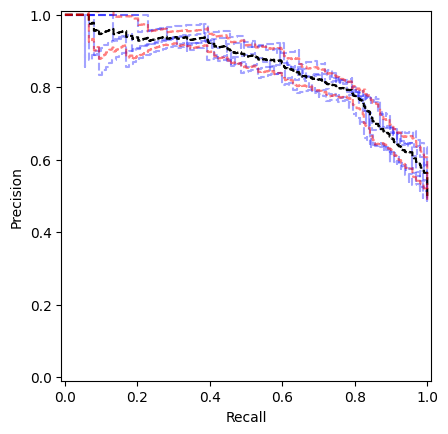

In [10]:
fig, ax = plt.subplots()

n_pr = len(all_pr)

# plot all pr curves
for k_pr in range(n_pr):
    pr = all_pr[k_pr]
    plot_pr_curve(pr, ax=ax, color="b", alpha=0.2)


# plot all mean pr curve
pr_mean, pr_mean_plus_std, pr_mean_minus_std = compute_mean_pr_curve(
    all_pr, n_samples=1000
)
plot_pr_curve(pr_mean, ax=ax, color="k", alpha=1)
plot_pr_curve(pr_mean_plus_std, ax=ax, color="r", alpha=0.5)
plot_pr_curve(pr_mean_minus_std, ax=ax, color="r", alpha=0.5)

In [11]:
score_mean = np.mean([compute_pr_score(pr) for pr in all_pr])
score_std = np.std([compute_pr_score(pr) for pr in all_pr])

print(f"The AP score is {score_mean:.2f} ({score_std:.2f}).")

The AP score is 0.86 (0.02).
